In [1]:
import xarray as xr
import numpy as np
import xmitgcm
from matplotlib import pyplot as plt
import os
from glob import glob
%matplotlib inline
from matplotlib.colors import LogNorm
import dask
from dask.diagnostics import ProgressBar
from xgcm import Grid

In [2]:
plt.rcParams['figure.figsize'] = (15,10)

plt.rcParams.update({'font.size': 18
    , 'legend.markerscale': 1., 'axes.titlesize': 18, 'axes.labelsize' : 18,
      'legend.fontsize' : 14,'legend.handlelength': 3})

plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

In [4]:
ddir = '/swot/SUM01/LLC/llc_4320_agulhas/'
all_files = sorted(glob(os.path.join(ddir, 'llc_4320_agulhas.0*.nc')))
print(len(all_files))
all_files[0], all_files[-1]

1752


('/swot/SUM01/LLC/llc_4320_agulhas/llc_4320_agulhas.0000010368.nc',
 '/swot/SUM01/LLC/llc_4320_agulhas/llc_4320_agulhas.0000262512.nc')

In [5]:
ds = xr.open_mfdataset(all_files[:24*70], decode_cf=False, autoclose=True, chunks={'k': 1, 'k_l': 1, 'time': 1})
#ds = xr.open_dataset(all_files[], decode_cf=False, chunks={'k': 1, 'k_l': 1})
ds = ds.set_coords(['iter', 'face'])

In [6]:
grid_ds = xr.open_dataset(ddir + 'llc_4320_agulhas_grid.nc')
ds = xr.merge([grid_ds, ds])
ds = xmitgcm.mds_store._swap_dimensions(ds, geometry='sphericalpolar')
ds_sec = ds.isel(YC = slice(1299,1501), YG = slice(1299,1501), XC = slice(999,1201), XG = slice(999,1201), Z=0, Zl=0,Zp1=0,Zu=0 )
#ds_sec = ds.isel(YC = slice(970,1650), XC = slice(985,1465), YG = slice(970,1650), XG = slice(985,1465), Z=0, Zl=0,Zp1=0,Zu=0  )
ds = ds_sec

grid = Grid(ds, periodic=False)
grid

<xgcm.Grid>
Y Axis (not periodic):
  * center   YC (202) --> left
  * left     YG (202) --> center
X Axis (not periodic):
  * center   XC (202) --> left
  * left     XG (202) --> center
T Axis (not periodic):
  * center   time (1680)

In [7]:
ds

<xarray.Dataset>
Dimensions:   (XC: 202, XG: 202, YC: 202, YG: 202, time: 1680)
Coordinates:
  * YC        (YC) float32 -40.369953 -40.355247 -40.340534 -40.325817 ...
  * YG        (YG) float32 -40.377308 -40.362602 -40.34789 -40.333176 ...
  * XC        (XC) float32 5.3229165 5.34375 5.3645835 5.3854165 5.40625 ...
  * XG        (XG) float32 5.3125 5.3333335 5.3541665 5.375 5.3958335 ...
    Zp1       float32 0.0
    Z         float32 -0.5
    Zl        float32 0.0
    Zu        float32 -1.0
  * time      (time) float64 2.592e+05 2.628e+05 2.664e+05 2.7e+05 2.736e+05 ...
Data variables:
    face      (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
    rA        (YC, XC) float32 ...
    rAw       (YC, XG) float32 ...
    rAs       (YG, XC) float32 ...
    rAz       (YG, XG) float32 ...
    dxG       (YG, XC) float32 ...
    dyG       (YC, XG) float32 ...
    dxC       (YC, XG) float32 ...
    Depth     (YC, XC) float32 ...
    dyC       (YG, XC) float32 ...
    PHre

In [9]:
ds2 = ds.drop(['Zp1','Z','Zl','Zu',
               'rA','rAw','rAs','rAz','dxG','dyG','Depth','PHrefF','PHrefC','drF','drC', 
              'hFacW','hFacS','hFacC','PhiBot','SIarea','SIheff','SIhsalt','SIhsnow','SIuice','SIvice',
              'Salt','Theta','W','oceFWflx','oceQnet','oceQsw','oceSflux'])
ds2

<xarray.Dataset>
Dimensions:  (XC: 202, XG: 202, YC: 202, YG: 202, time: 1680)
Coordinates:
  * YC       (YC) float32 -40.369953 -40.355247 -40.340534 -40.325817 ...
  * YG       (YG) float32 -40.377308 -40.362602 -40.34789 -40.333176 ...
  * XC       (XC) float32 5.3229165 5.34375 5.3645835 5.3854165 5.40625 ...
  * XG       (XG) float32 5.3125 5.3333335 5.3541665 5.375 5.3958335 ...
  * time     (time) float64 2.592e+05 2.628e+05 2.664e+05 2.7e+05 2.736e+05 ...
Data variables:
    face     (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
    dxC      (YC, XG) float32 ...
    dyC      (YG, XC) float32 ...
    Eta      (time, YC, XC) float32 dask.array<shape=(1680, 202, 202), chunksize=(1, 202, 202)>
    U        (time, YC, XG) float32 dask.array<shape=(1680, 202, 202), chunksize=(1, 202, 202)>
    V        (time, YG, XC) float32 dask.array<shape=(1680, 202, 202), chunksize=(1, 202, 202)>
    iter     (time) int64 dask.array<shape=(1680,), chunksize=(1,)>
    oceTAUX 

# Linear Regression#

Given a Dataset $\left[ y_i, x_{i1}, ... , x_{i\beta}\right]_{i=1}^{n}$


For the first exercise, we aim to fit a multiple linear regression. For our black box therefore the input variables are $\left[x_{i1}, ... , x_{ip}\right]_{i=1}^{n}$, n being the number of samples, and p being the number of features. We can represent the linear regression problem as $u_i = \beta_0 1 + \beta_1 x_{i1} + ... + \beta_p x_{ip} + \epsilon_i$.

$$
X=
  \begin{bmatrix}
    1 & x_{11} & x_{12} ...  & x_{1p} \\
    1 & x_{21} & x_{22} ...  & x_{2p} \\
    .. & ..  & .... &...\\
    1 & x_{n1} & x_{n2} ...  & x_{np}
  \end{bmatrix}
$$

or 

$$
X = \begin{bmatrix}
    x_1^T \\
    x_2^T \\
    .. \\
    x_n^T
  \end{bmatrix}
$$

and 

$$
\beta = \begin{bmatrix}
    \beta_0 \\
    \beta_1 \\
    .. \\
    \beta_p
  \end{bmatrix}
$$

$$
U= \begin{bmatrix}
    u_0 \\
    u_1 \\
    .. \\
    u_n
  \end{bmatrix}
$$

$$
\epsilon = \begin{bmatrix}
    \epsilon_0 \\
    \epsilon_1 \\
    .. \\
    \epsilon_n
  \end{bmatrix}
$$

For our example our 9 features (variables) are $[f, \tau_x,\tau_y, \eta_{x+}, \eta_{x-}, \eta_{y+}, \eta_{y-}, \frac{1}{dx}, \frac{1}{dy}]$ .

where $U$ and $\beta$ are complex valued. For vectorization we consider them to have 2 columns each

$$
U = \begin{bmatrix}
    u_1 & v_1\\
    u_2 & v_2\\
    .. \\
    u_n & v_n
  \end{bmatrix}
$$

and 

$$
\beta = \begin{bmatrix}
        \beta_{0r} & \beta_{0i}\\
        \beta_{1r} & \beta_{1i}\\
        .. \\
        \beta_{pr} & \beta_{pi}
  \end{bmatrix}
$$

Our linear regression problem is therefore 
$$
\underbrace{\begin{bmatrix}
    u_1 & v_1\\
    u_2 & v_2\\
    .. \\
    u_n & v_n
  \end{bmatrix}}_{u = [n (samples) \times 2]} =
  \underbrace{\begin{bmatrix}
    1 & x_{11} & x_{12} ...  & x_{19} \\
    1 & x_{21} & x_{22} ...  & x_{29} \\
    .. & ..  & .... &...\\
    1 & x_{n1} & x_{n2} ...  & x_{n9}
  \end{bmatrix}}_{X = \left[n (samples) \times [9(features)+1]\right]} 
  \cdot
  \underbrace{\begin{bmatrix}
        \beta_{0r} & \beta_{0i}\\
        \beta_{1r} & \beta_{1i}\\
        .. \\
        \beta_{9r} & \beta_{9i}
  \end{bmatrix}}_{\beta = \left[[9(coefficients)+1(intercept)] \times 2\right]}
$$

or 
$$\mathbf{u} = \beta_0 + \beta_1 \cdot \underbrace{[f_{x,y}]}_{x_1} + \beta_2 \cdot \underbrace{[\tau^x_{x,y}]}_{x_2} + \beta_3 \cdot \underbrace{[\tau^y_{x,y}]}_{x_3} 
+ \beta_4 \cdot \underbrace{[\eta_{x+,y}]}_{x_4} + \beta_5 \cdot \underbrace{[\eta_{x-,y}]}_{x_5} + \beta_6 \cdot \underbrace{[\eta_{x,y+}]}_{x_6}  + \beta_7 \cdot \underbrace{[\eta_{x,y-}]}_{x_7}  + \beta_8 \cdot \underbrace{[\frac{1}{dx}_{x,y}]}_{x_8} + \beta_9 \cdot \underbrace{[\frac{1}{dy}_{x,y}]}_{x_9}$$

# Our insight #

Based on our null hypothesis that 
$$ \mathbf{u} = \mathbf{u_g} + \mathbf{u_{ek}}$$

$$\mathbf{u} = 
\frac{-g}{2} \left([\eta_{x,y+}] - [\eta_{x,y-}]\right) [\frac{1}{dy_{x,y}}] [f_{x,y}]^{-1} + 
\frac{1}{\rho \sqrt{2 A_z}} [f_{x,y}]^{-1/2}\left([\tau^x_{x,y}] - [\tau^y_{x,y}] \right) + 
\hat{i} \frac{g}{2} \left([\eta_{x+,y}] - [\eta_{x-,y}]\right) [\frac{1}{dx_{x,y}}] [f_{x,y}]^{-1} + 
\hat{i} \frac{1}{\rho \sqrt{2 A_z}} [f_{x,y}]^{-1/2}\left([\tau^x_{x,y}] + [\tau^y_{x,y}] \right)
$$

$$\mathbf{u} = 
\frac{-g}{2} \left( [x_6] - [x_7] \right) [x_9] [x_1]^{-1} + 
\frac{1}{\rho \sqrt{2 A_z}} [x_1]^{-1/2}\left([x_2] - [x_3] \right) + 
\hat{i} \frac{g}{2} \left([x_4] - [x_5]\right) [x_8] [x_1]^{-1} + 
\hat{i} \frac{1}{\rho \sqrt{2 A_z}} [x_1]^{-1/2}\left([x_2] + [x_3] \right)
$$

$$
\mathbf{u} = 
[-c_1,0] \underbrace{(x_1^{-1}x_6 x_9)}_{y_1} + 
[c_1, 0] \underbrace{(x_1^{-1} x_7 x_9)}_{y_2} + 
[0,c_1] \underbrace{(x_1^{-1}x_4 x_8)}_{y_3} + 
[0,-c_1] \underbrace{(x_1^{-1} x_5 x_8)}_{y_4} +
[c2, c2] \underbrace{(x_1^{-1/2} x_2)}_{y_5} + 
[-c_2, c_2] \underbrace{(x_1^{-1/2} x_3)}_{y_6}
$$

where $c_1 =\frac{g}{2}$ and $c_2 = \frac{1}{\rho \sqrt{2 A_z}}$ 
This represents our null hypothesis where the coefficients are 
$$
\theta = \begin{bmatrix}
        -c_1 & 0\\
        c_1 & 0\\
        0 & c_1\\
        0 & -c_1\\
        c_2 & c_2\\
        -c_2 & c_2
  \end{bmatrix}
$$

The new linear regression problem now becomes

$$\mathbf{u} = 
\theta_0 + \theta_1 \underbrace{(x_1^{-1}x_6 x_9)}_{y_1} + 
\theta_2 \underbrace{(x_1^{-1} x_7 x_9)}_{y_2} + 
\theta_3 \underbrace{(x_1^{-1}x_4 x_8)}_{y_3} + 
\theta_4 \underbrace{(x_1^{-1} x_5 x_8)}_{y_4} +
\theta_5 \underbrace{(x_1^{-1/2} x_2)}_{y_5} + 
\theta_6 \underbrace{(x_1^{-1/2} x_3)}_{y_6}
$$

Or we can write in vector form as

$$
\underbrace{\begin{bmatrix}
    u_1 & v_1\\
    u_2 & v_2\\
    .. \\
    u_n & v_n
  \end{bmatrix}}_{u = [n (samples) \times 2]} =
  \underbrace{\begin{bmatrix}
    1 & y_{11} & y_{12} ...  & y_{16} \\
    1 & y_{21} & y_{22} ...  & y_{26} \\
    .. & ..  & .... &...\\
    1 & y_{n1} & y_{n2} ...  & y_{n6}
  \end{bmatrix}}_{Y = \left[n (samples) \times [6(features)+1]\right]} 
  \cdot
  \underbrace{\begin{bmatrix}
        \theta_{0r} & \theta_{0i}\\
        \theta_{1r} & \theta_{1i}\\
        .. \\
        \theta_{6r} & \theta_{6i}
  \end{bmatrix}}_{\beta = \left[[6(coefficients)+1(intercept)] \times 2\right]}
$$

In [ ]:
#with ProgressBar():
#    ds3 = ds2.load()

In [10]:
u = (grid.interp(ds2.U, 'X', boundary='extend')).isel(XC=slice(1,-1), YC=slice(1,-1))
v = (grid.interp(ds2.V, 'Y', boundary='extend')).isel(XC=slice(1,-1), YC=slice(1,-1))

tau_x = (grid.interp(ds2.oceTAUX, 'X', boundary='extend')).isel(XC=slice(1,-1), YC=slice(1,-1))
tau_y = (grid.interp(ds2.oceTAUY, 'Y', boundary='extend')).isel(XC=slice(1,-1), YC=slice(1,-1))

eta_xp = ds2.Eta.roll(XC=-1).isel(XC=slice(1,-1), YC=slice(1,-1))
eta_xm = ds2.Eta.roll(XC=1).isel(XC=slice(1,-1), YC=slice(1,-1))
eta_yp = ds2.Eta.roll(YC=-1).isel(XC=slice(1,-1), YC=slice(1,-1))
eta_ym = ds2.Eta.roll(YC=1).isel(XC=slice(1,-1), YC=slice(1,-1))


In [15]:
with ProgressBar():
    u_val = u[::24].values
    v_val = v[::24].values
    tau_x_val = tau_x[::24].values
    tau_y_val = tau_x[::24].values
    eta_xp_val = eta_xp[::24].values
    eta_xm_val = eta_xm[::24].values
    eta_yp_val = eta_yp[::24].values
    eta_ym_val = eta_ym[::24].values

[########################################] | 100% Completed | 28.9s
[########################################] | 100% Completed | 38.8s
[########################################] | 100% Completed | 24.8s
[########################################] | 100% Completed | 17.5s
[########################################] | 100% Completed | 17.6s
[########################################] | 100% Completed | 15.4s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.2s


In [17]:
u_val.shape

(70, 200, 200)

In [18]:
#times = u.time.shape[0]
#XCs = u.XC.shape[0]
#YCs = u.YC.shape[0]
#d1 = np.zeros([times,YCs,XCs])
#d1.shape

inv_dx_val = np.zeros_like(u_val, np.float32)
inv_dy_val = np.zeros_like(u_val, np.float32)

inv_dx_val[:] = ((1.0/(grid.interp(ds.dxC, 'X', boundary='extend'))).isel(XC=slice(1,-1), YC=slice(1,-1), drop=True)).values
inv_dy_val[:] = ((1.0/(grid.interp(ds.dyC, 'Y', boundary='extend'))).isel(XC=slice(1,-1), YC=slice(1,-1), drop=True)).values

Om = 7.2921e-5
f_c = np.abs(2 * Om * np.sin(np.deg2rad(ds.YC.isel(YC=slice(1,-1), drop=True)))).values

f_val = np.zeros_like(u_val, np.float32)
f_val[:] = f_c[np.newaxis,:,np.newaxis]



In [29]:
inv_dx_val[50:70].shape

(20, 200, 200)

In [33]:
X1 = np.ravel(f_val[0:50])
X2 = np.ravel(tau_x_val[0:50])
X3 = np.ravel(tau_y_val[0:50])
X4 = np.ravel(eta_xp_val[0:50])
X5 = np.ravel(eta_xm_val[0:50])
X6 = np.ravel(eta_yp_val[0:50])
X7 = np.ravel(eta_ym_val[0:50])
X8 = np.ravel(inv_dx_val[0:50])
X9 = np.ravel(inv_dy_val[0:50])

X_bar = np.array([X1, X2, X3, X4, X5, X6, X7, X8, X9]).T
X_bar.shape

(2000000, 9)

In [34]:
X1_t = np.ravel(f_val[50:70])
X2_t = np.ravel(tau_x_val[50:70])
X3_t = np.ravel(tau_y_val[50:70])
X4_t = np.ravel(eta_xp_val[50:70])
X5_t = np.ravel(eta_xm_val[50:70])
X6_t = np.ravel(eta_yp_val[50:70])
X7_t = np.ravel(eta_ym_val[50:70])
X8_t = np.ravel(inv_dx_val[50:70])
X9_t = np.ravel(inv_dy_val[50:70])

X_t_bar = np.array([X1_t, X2_t, X3_t, X4_t, X5_t, X6_t, X7_t, X8_t, X9_t]).T
X_t_bar.shape


(800000, 9)

In [35]:
U = np.array([np.ravel(u_val[0:50]),np.ravel(v_val[0:50])]).T
U.shape

(2000000, 2)

In [36]:
U_truth = np.array([np.ravel(u_val[50:70]),np.ravel(v_val[50:70])]).T
U_truth.shape

(800000, 2)

In [111]:
Y1 = X6*X9/X1
Y2 = X7*X9/X1
Y3 = X4*X8/X1
Y4 = X5*X8/X1
Y5 = (np.abs(X1))**-0.5 * X2
Y6 = (np.abs(X1))**-0.5 * X3

Y_bar = np.array([Y1, Y2, Y3, Y4, Y5, Y6]).T

Y1_t = X6_t*X9_t/X1_t
Y2_t = X7_t*X9_t/X1_t
Y3_t = X4_t*X8_t/X1_t
Y4_t = X5_t*X8_t/X1_t
Y5_t = (np.abs(X1_t))**-0.5 * X2_t
Y6_t = (np.abs(X1_t))**-0.5 * X3_t

Y_t_bar = np.array([Y1_t, Y2_t, Y3_t, Y4_t, Y5_t, Y6_t]).T


In [112]:
from sklearn import linear_model

In [113]:
reg = linear_model.LinearRegression()

In [114]:
reg.fit(X_bar,U)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [115]:
beta = reg.coef_

In [116]:
beta.shape

(2, 9)

In [117]:
beta

array([[ 8.0260513e+01,  1.5483201e-01,  3.6149895e-01, -3.4867384e+00,
        -3.1520557e+00,  3.6251488e+01, -2.9619831e+01,  3.1573871e+02,
         3.1748865e+02],
       [-6.5353722e+01,  1.8826196e-01,  1.9947389e-02, -2.6422363e+01,
         3.3100742e+01, -3.8070345e+00, -2.8566301e+00, -2.5709607e+02,
        -2.5852106e+02]], dtype=float32)

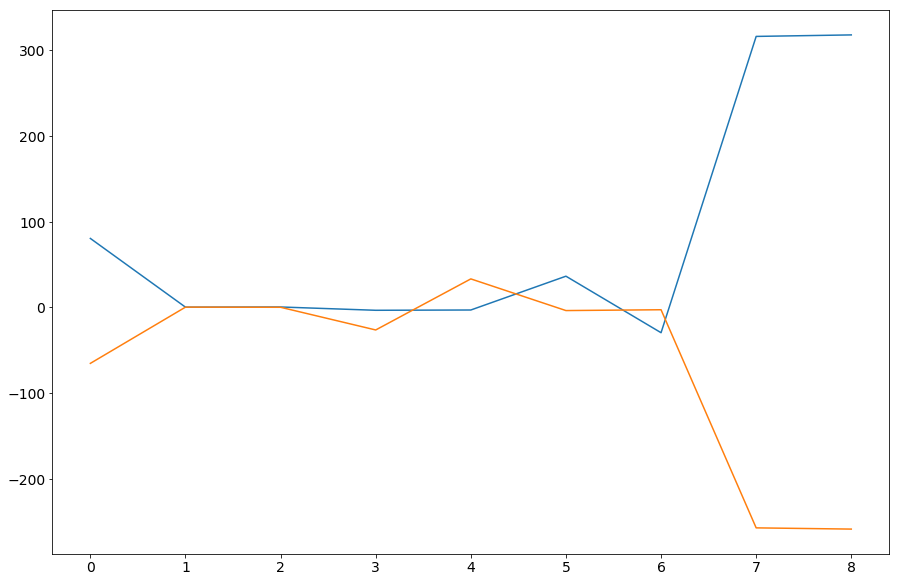

In [118]:
plt.plot(beta.T);

In [119]:
reg2 = linear_model.LinearRegression()
reg2.fit(Y_bar,U)

beta2 = reg2.coef_

In [120]:
beta2.shape

(2, 6)

In [121]:
beta2

array([[ 4.7518487 , -5.34562   ,  0.29245448,  0.34822202,  1.3427205 ,
        -1.3377604 ],
       [-0.15134974,  0.02244966, -4.8543854 ,  4.9960914 , -9.85714   ,
         9.859119  ]], dtype=float32)

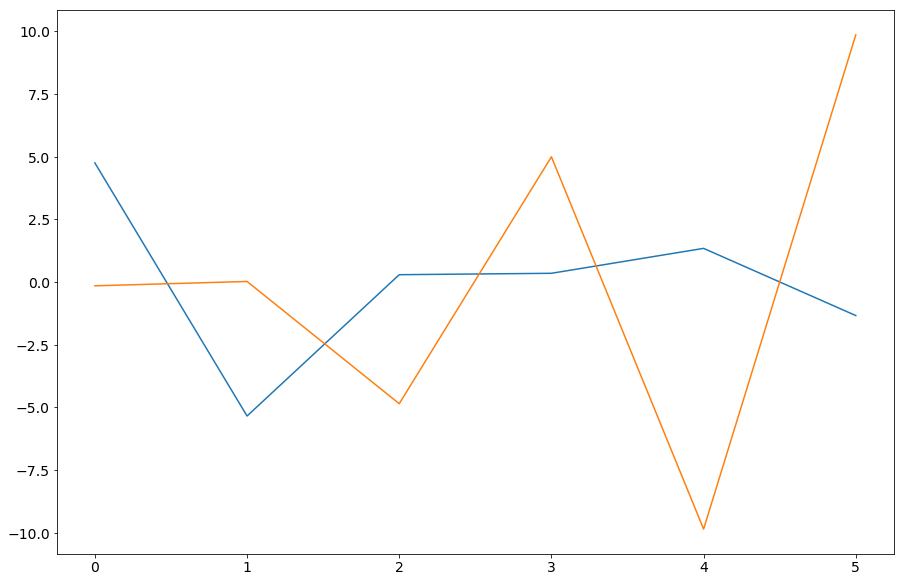

In [122]:
plt.plot(beta2.T);

In [123]:
scr1 = reg.score(X_bar,U)

In [124]:
scr2 = reg2.score(Y_bar,U)

In [125]:
scr1

0.8736556693004919

In [126]:
scr2

0.8729857600840711

In [127]:
Ut = reg.predict(X_t_bar)
Ut2 = reg2.predict(Y_t_bar)

In [128]:
Ut.shape, Ut2.shape

((800000, 2), (800000, 2))

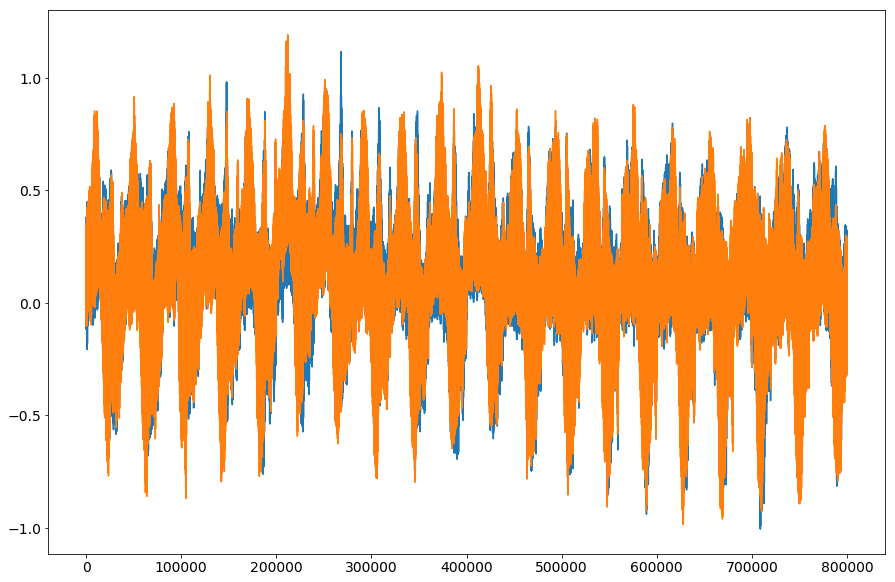

In [129]:
plt.plot(Ut[:,0])
plt.plot(U_truth[:,0])

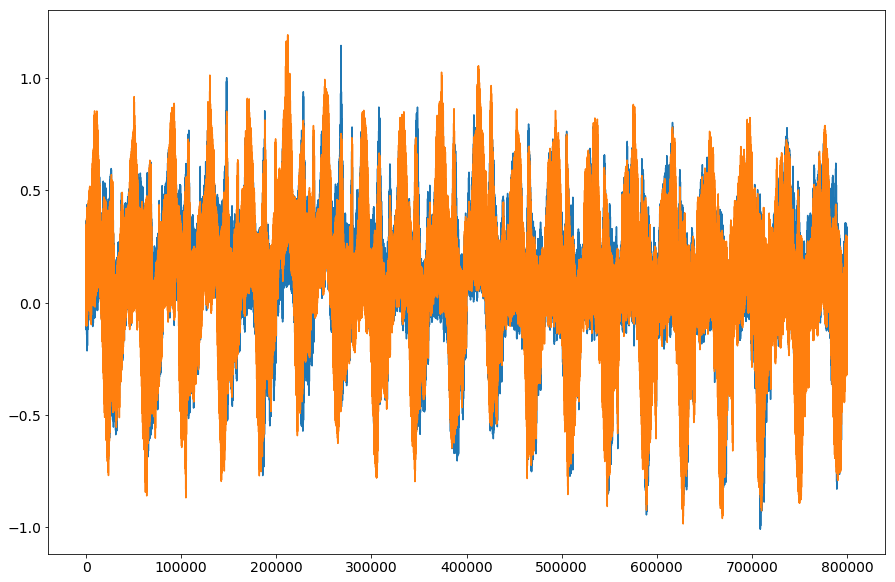

In [130]:
plt.plot(Ut2[:,0])
plt.plot(U_truth[:,0])

In [131]:
Utest = Ut[:,0].reshape(u_val[50:70].shape)
Vtest = Ut[:,1].reshape(u_val[50:70].shape)

Utest2 = Ut2[:,0].reshape(u_val[50:70].shape)
Vtest2 = Ut2[:,1].reshape(u_val[50:70].shape)

Utruth = U_truth[:,0].reshape(u_val[50:70].shape)
Vtruth = U_truth[:,1].reshape(u_val[50:70].shape)



In [132]:
Utest.shape, Utruth.shape

((20, 200, 200), (20, 200, 200))

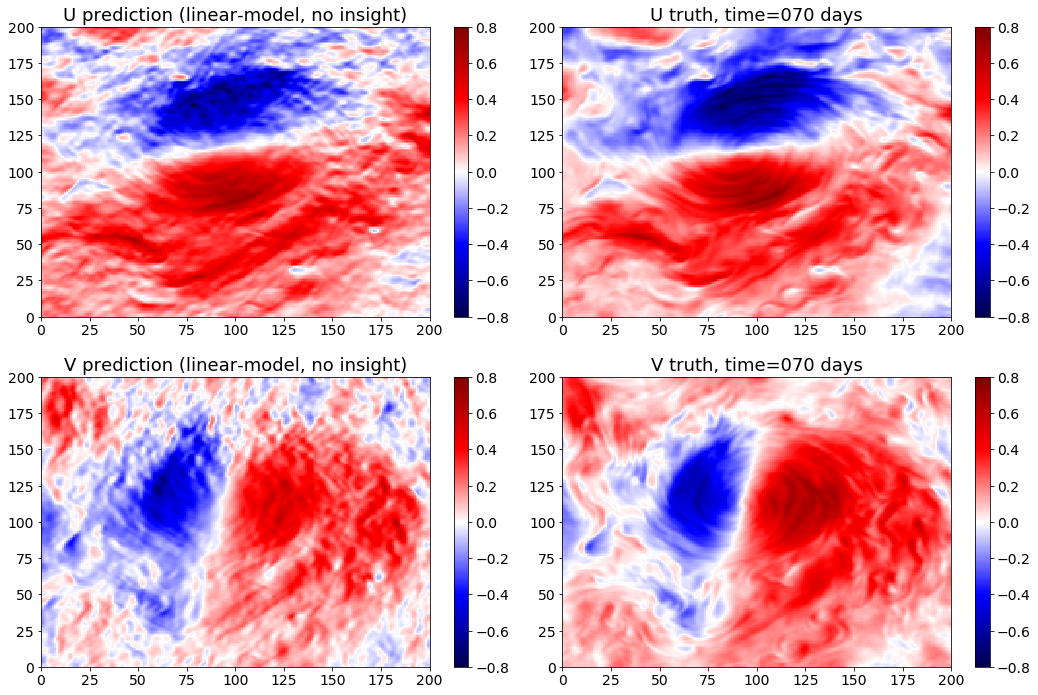

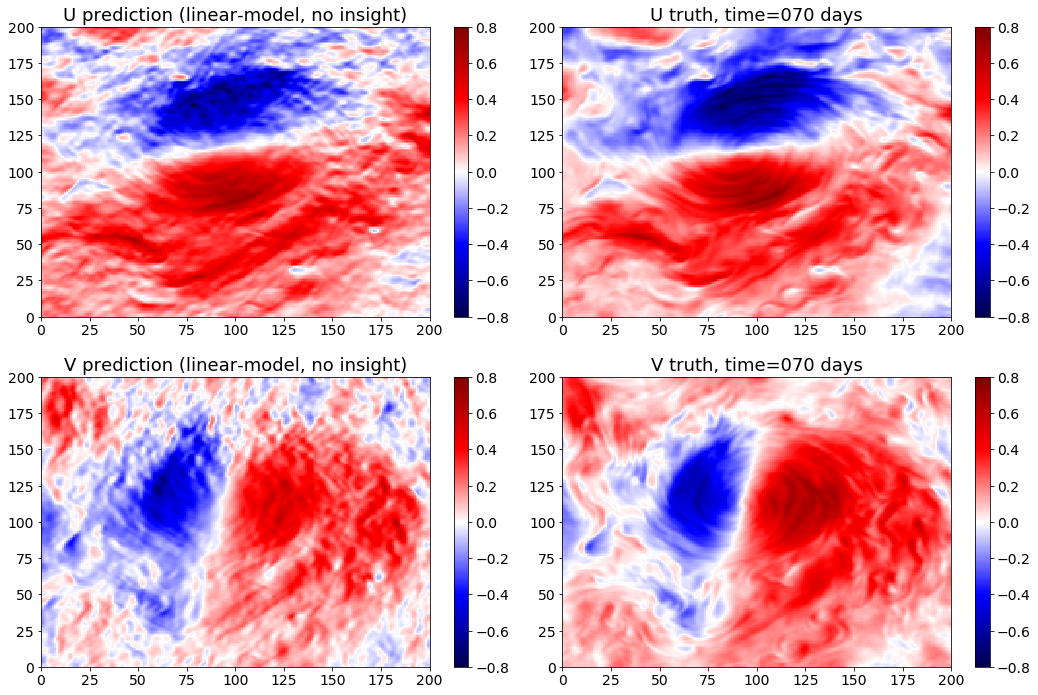

In [133]:
figdir ='figs_lin_model/'

fig = plt.figure(figsize=(15,10))

from IPython.display import display, clear_output
import time

import os

for i in range(20):
    fig.clf()
    plt.subplot(221)
    plt.pcolormesh(Utest[i], cmap='seismic');plt.clim([-0.8,0.8]);
    plt.colorbar();plt.title('U prediction (linear-model, no insight)')
    
    plt.subplot(222)
    plt.pcolormesh(Utruth[i], cmap='seismic');plt.clim([-0.8,0.8]);
    plt.colorbar();plt.title('U truth, time=%03d days' %(i+51))

    plt.subplot(223)
    plt.pcolormesh(Vtest[i], cmap='seismic');plt.clim([-0.8,0.8]);
    plt.colorbar();plt.title('V prediction (linear-model, no insight)')

    plt.subplot(224)
    plt.pcolormesh(Vtruth[i], cmap='seismic');plt.clim([-0.8,0.8]);
    plt.colorbar();plt.title('V truth, time=%03d days' %(i+51))
    plt.tight_layout()
    
    fig.savefig(figdir+'UV_lin_mod_no_insight_%05d'%i)

    clear_output(wait=True)
    display(plt.gcf())
    i+=1



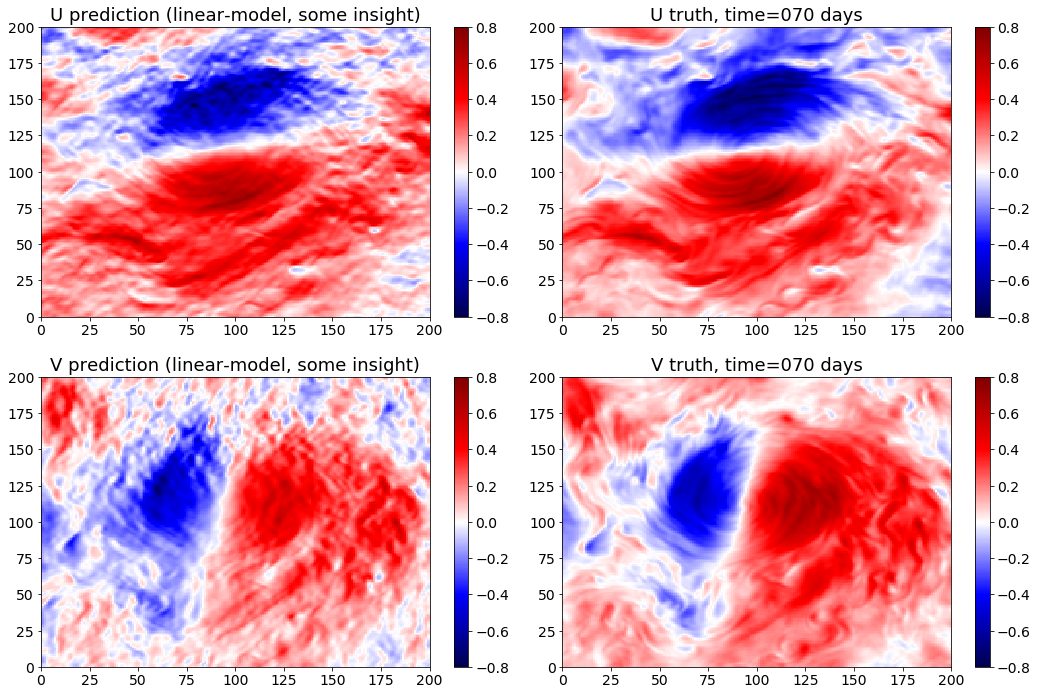

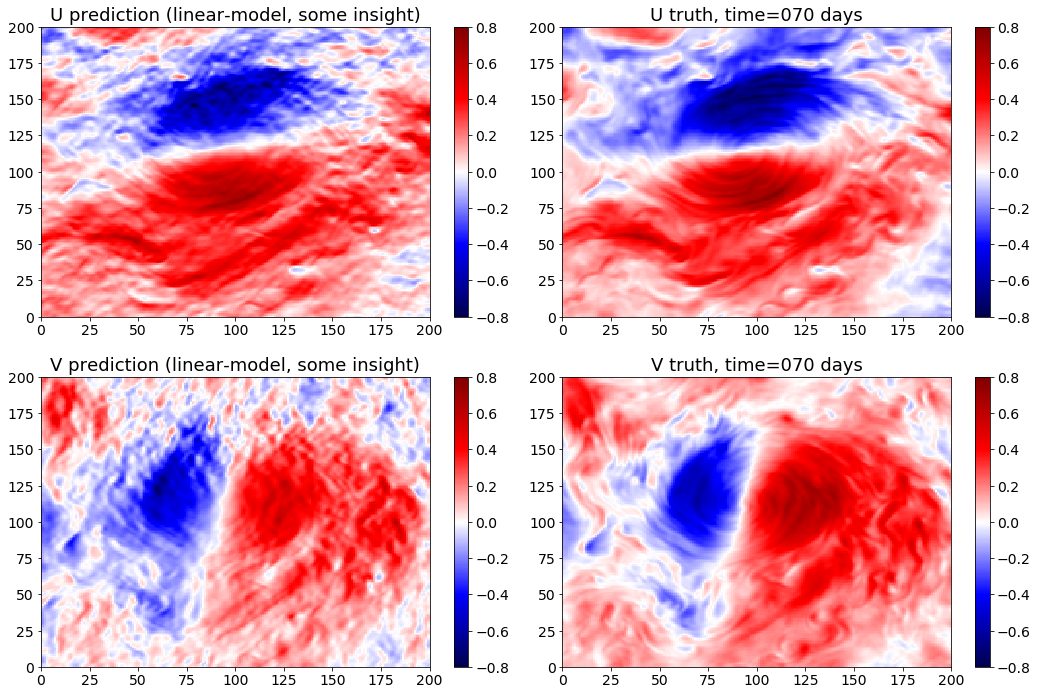

In [134]:
figdir ='figs_lin_model/'

fig = plt.figure(figsize=(15,10))


for i in range(20):
    fig.clf()
    plt.subplot(221)
    plt.pcolormesh(Utest2[i], cmap='seismic');plt.clim([-0.8,0.8]);
    plt.colorbar();plt.title('U prediction (linear-model, some insight)')
    
    plt.subplot(222)
    plt.pcolormesh(Utruth[i], cmap='seismic');plt.clim([-0.8,0.8]);
    plt.colorbar();plt.title('U truth, time=%03d days' %(i+51))

    plt.subplot(223)
    plt.pcolormesh(Vtest2[i], cmap='seismic');plt.clim([-0.8,0.8]);
    plt.colorbar();plt.title('V prediction (linear-model, some insight)')

    plt.subplot(224)
    plt.pcolormesh(Vtruth[i], cmap='seismic');plt.clim([-0.8,0.8]);
    plt.colorbar();plt.title('V truth, time=%03d days' %(i+51))
    plt.tight_layout()
    
    fig.savefig(figdir+'UV_lin_mod_some_insight_%05d'%i)

    clear_output(wait=True)
    display(plt.gcf())
    i+=1


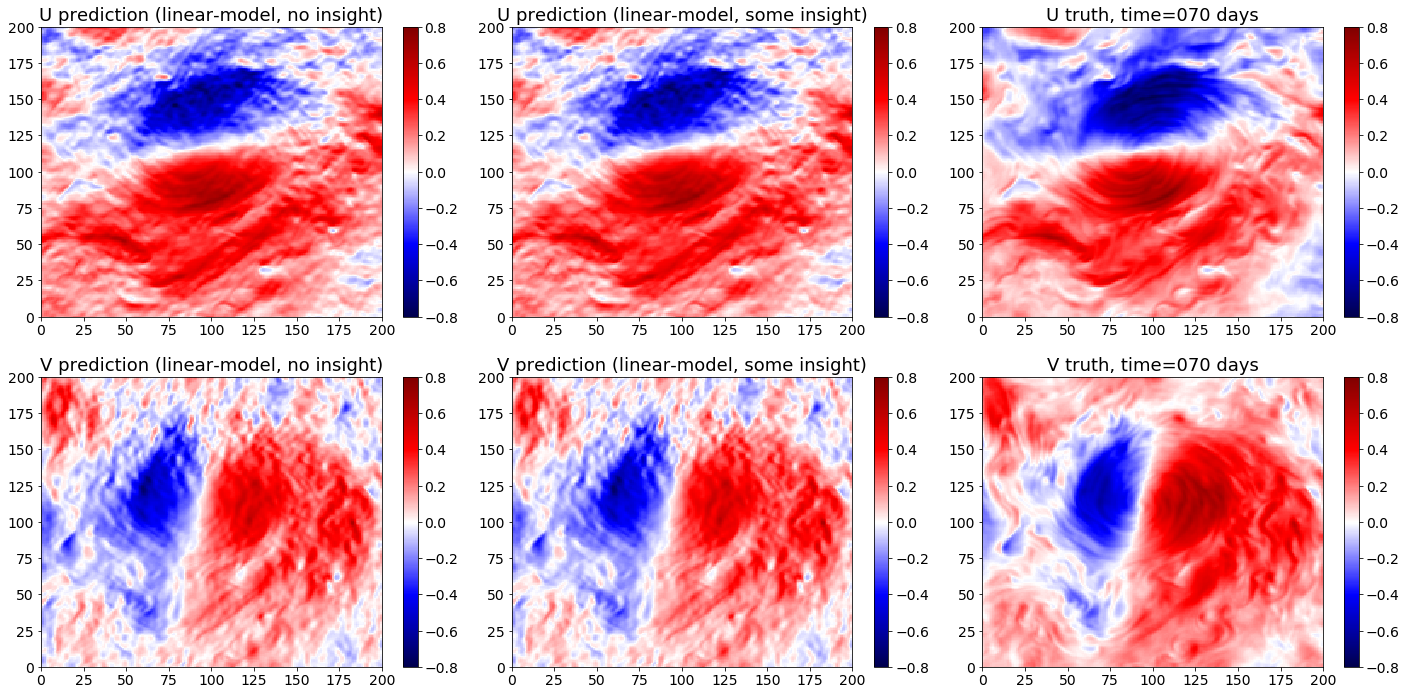

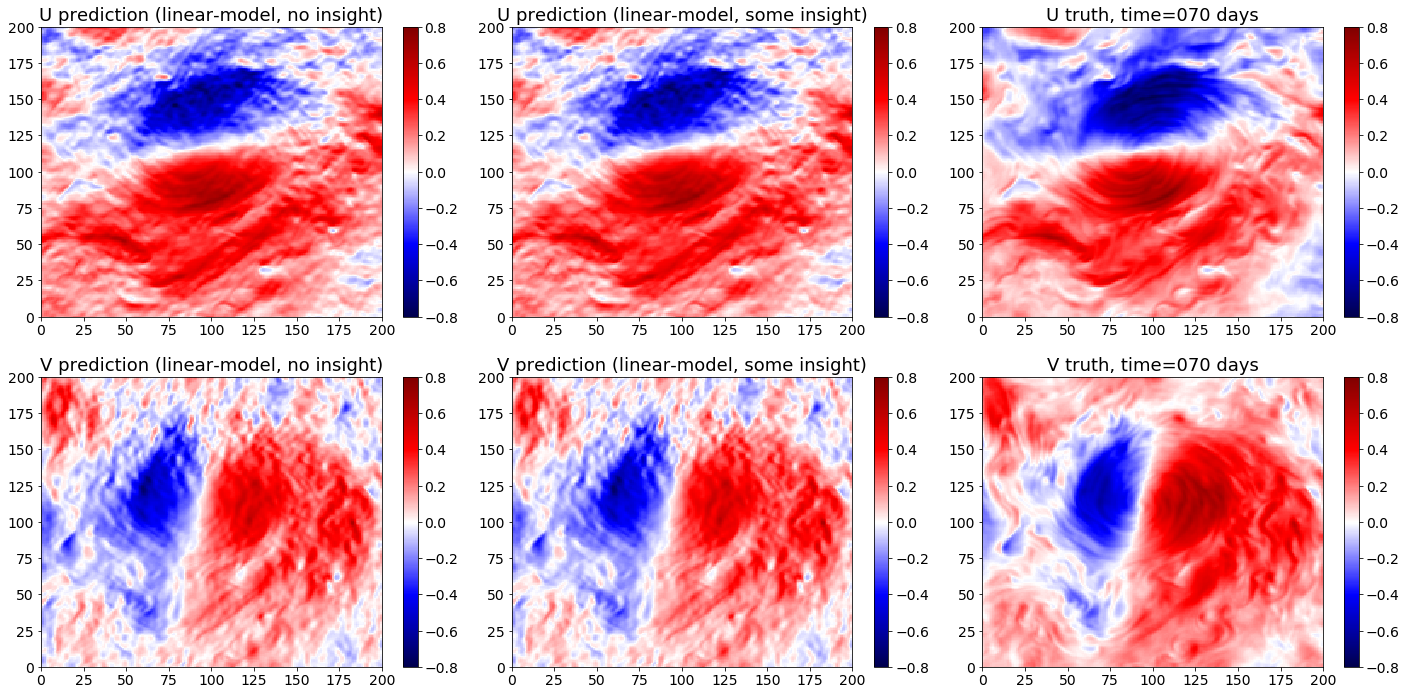

In [135]:
fig = plt.figure(figsize=(20,10))


for i in range(20):
    fig.clf()
    
    plt.subplot(231)
    plt.pcolormesh(Utest[i], cmap='seismic');plt.clim([-0.8,0.8]);
    plt.colorbar();plt.title('U prediction (linear-model, no insight)')
    
    plt.subplot(232)
    plt.pcolormesh(Utest2[i], cmap='seismic');plt.clim([-0.8,0.8]);
    plt.colorbar();plt.title('U prediction (linear-model, some insight)')
    
    plt.subplot(233)
    plt.pcolormesh(Utruth[i], cmap='seismic');plt.clim([-0.8,0.8]);
    plt.colorbar();plt.title('U truth, time=%03d days' %(i+51))

    plt.subplot(234)
    plt.pcolormesh(Vtest[i], cmap='seismic');plt.clim([-0.8,0.8]);
    plt.colorbar();plt.title('V prediction (linear-model, no insight)')
    
    plt.subplot(235)
    plt.pcolormesh(Vtest2[i], cmap='seismic');plt.clim([-0.8,0.8]);
    plt.colorbar();plt.title('V prediction (linear-model, some insight)')

    plt.subplot(236)
    plt.pcolormesh(Vtruth[i], cmap='seismic');plt.clim([-0.8,0.8]);
    plt.colorbar();plt.title('V truth, time=%03d days' %(i+51))
    plt.tight_layout()
    
    fig.savefig(figdir+'UV_lin_mod_%05d'%i)

    clear_output(wait=True)
    display(plt.gcf())
    i+=1


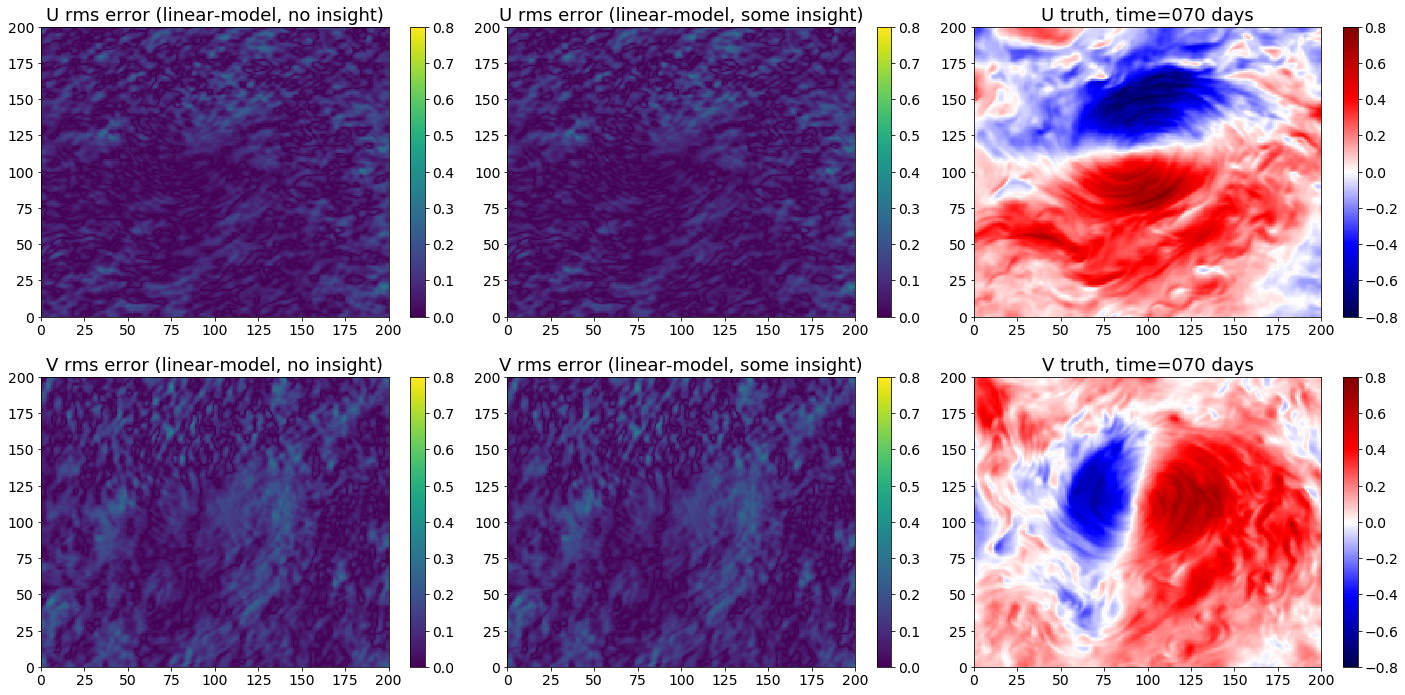

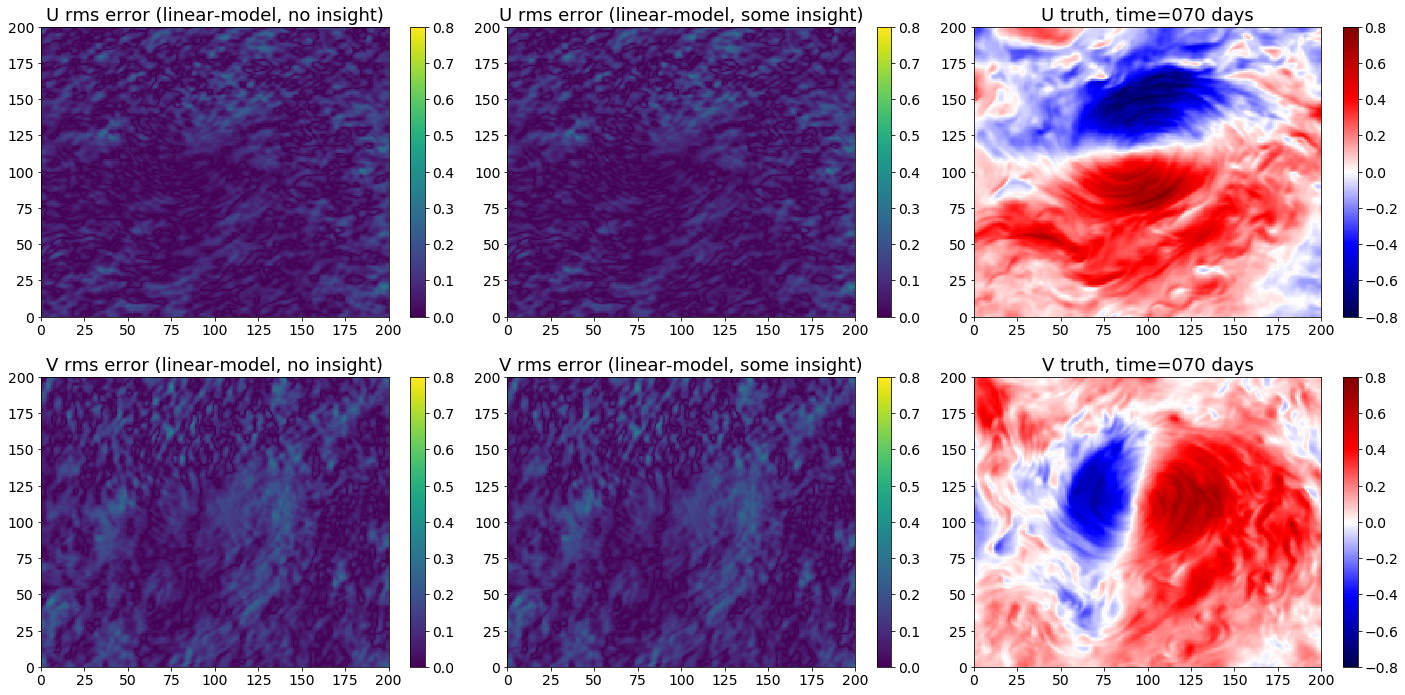

In [136]:
fig = plt.figure(figsize=(20,10))


for i in range(20):
    fig.clf()
    
    plt.subplot(231)
    plt.pcolormesh(np.sqrt((Utest[i] - Utruth[i])**2));plt.clim([0,0.8]);
    plt.colorbar();plt.title('U rms error (linear-model, no insight)')
    
    plt.subplot(232)
    plt.pcolormesh(np.sqrt((Utest2[i] - Utruth[i])**2));plt.clim([0,0.8]);
    plt.colorbar();plt.title('U rms error (linear-model, some insight)')
    
    plt.subplot(233)
    plt.pcolormesh(Utruth[i], cmap='seismic');plt.clim([-0.8,0.8]);
    plt.colorbar();plt.title('U truth, time=%03d days' %(i+51))

    plt.subplot(234)
    plt.pcolormesh(np.sqrt((Vtest[i] - Vtruth[i])**2));plt.clim([0,0.8]);
    plt.colorbar();plt.title('V rms error (linear-model, no insight)')
    
    plt.subplot(235)
    plt.pcolormesh(np.sqrt((Vtest2[i] - Vtruth[i])**2));plt.clim([0,0.8]);
    plt.colorbar();plt.title('V rms error (linear-model, some insight)')

    plt.subplot(236)
    plt.pcolormesh(Vtruth[i], cmap='seismic');plt.clim([-0.8,0.8]);
    plt.colorbar();plt.title('V truth, time=%03d days' %(i+51))
    plt.tight_layout()
    
    fig.savefig(figdir+'UV_lin_mod__error_%05d'%i)

    clear_output(wait=True)
    display(plt.gcf())
    i+=1

In [148]:
U_err = (np.sqrt((Utest - Utruth)**2)/np.abs(Utruth)).mean(axis=(1,2))
V_err = (np.sqrt((Vtest - Vtruth)**2)/np.abs(Vtruth)).mean(axis=(1,2))

U_err2 = (np.sqrt((Utest2 - Utruth)**2)/np.abs(Utruth)).mean(axis=(1,2))
V_err2 = (np.sqrt((Vtest2 - Vtruth)**2)/np.abs(Vtruth)).mean(axis=(1,2))

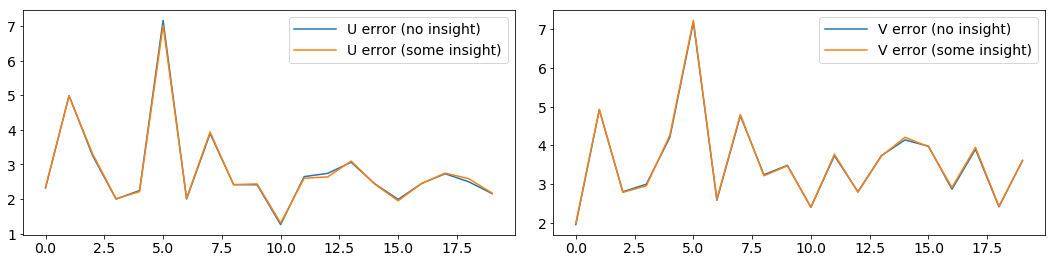

In [149]:
fig = plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(U_err, label='U error (no insight)')
plt.plot(U_err2, label='U error (some insight)')
plt.legend()
plt.subplot(122)
plt.plot(V_err, label='V error (no insight)')
plt.plot(V_err2, label='V error (some insight)')
plt.legend()
plt.tight_layout()
